# Evaluation of models trained on the MHS dataset

In [1]:
import os
import pandas as pd
import pickle
import datasets
from sklearn.metrics import classification_report

## Majority vote model

### Evaluation on the MHS dataset

Evaluating the majority vote model trained on MHS data against the test MHS data with annotator-specific labels.

In [31]:
MHS_TEST_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_test.csv'

ANNOTATORS_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/annotators_data_mhs.csv'

PREDICTED_LOGITS_MAJORITY_VOTE_MHS_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/mhs/majority_vote_model_mhs_run_1/checkpoint_200_mhs_test_predicted_logits.pkl'

In [41]:
mhs_test_data = pd.read_csv(MHS_TEST_DATA_PATH)

# Aggregated labels by majority vote.
mhs_test_data_majority_vote = mhs_test_data.groupby('text_id').agg(
    text=pd.NamedAgg('text', 'first'),
    toxic_score=pd.NamedAgg(
        'toxic_score',
        lambda group: group.value_counts(ascending=False).index[0]
    )
).reset_index()

Add the model's predictions to the majority vote dataset, then join with the annotator-specific dataset.

In [55]:
with open(PREDICTED_LOGITS_MAJORITY_VOTE_MHS_PATH, 'rb') as f:
    predicted_logits_majority_vote_mhs = pickle.load(f)

mhs_test_data_majority_vote['majority_vote_predicted_toxic_score'] = predicted_logits_majority_vote_mhs.argmax(dim=-1).cpu().numpy()

mhs_test_data = pd.merge(
    left=mhs_test_data,
    right=mhs_test_data_majority_vote[['text_id', 'majority_vote_predicted_toxic_score']],
    how='left',
    on='text_id'
)

In [56]:
mhs_test_data

,text_id,annotator_id,toxic_score,text,extreme_annotator,majority_vote_predicted_toxic_score
0,29107,1671,0,Fuck a bitch named Uterus.,False,1
1,40501,146,1,no one fucking cares fag,False,1
2,20599,4719,1,You criminals have perfected this art of media...,False,0
3,33260,3475,0,7/22/19: Israeli soldiers and border police bl...,True,0
4,18799,5341,0,Forget about them lets start a holocaust and k...,False,0
...,...,...,...,...,...,...
2252,20063,5649,0,"Lady in the back Blinks when ""her"" camera red ...",False,0
2253,20063,2655,0,"Lady in the back Blinks when ""her"" camera red ...",False,0
2254,20067,1666,0,"Please help support nonbinary pride, add a #Tw...",False,0
2255,20063,7017,0,"Lady in the back Blinks when ""her"" camera red ...",False,0


In [57]:
print('Evaluation on the whole dataset')
print('-------------------------------')
print(classification_report(
    y_true=mhs_test_data['toxic_score'],
    y_pred=mhs_test_data['majority_vote_predicted_toxic_score']
))

print('\n')
print('Evaluation on extreme annotators only')
print('-------------------------------------')
print(classification_report(
    y_true=mhs_test_data[mhs_test_data['extreme_annotator']]['toxic_score'],
    y_pred=mhs_test_data[mhs_test_data['extreme_annotator']]['majority_vote_predicted_toxic_score']
))


print('\n')
print('Evaluation on non-extreme annotators only')
print('-----------------------------------------')
print(classification_report(
    y_true=mhs_test_data[~mhs_test_data['extreme_annotator']]['toxic_score'],
    y_pred=mhs_test_data[~mhs_test_data['extreme_annotator']]['majority_vote_predicted_toxic_score']
))

Evaluation on the whole dataset
-------------------------------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1211
           1       0.84      0.79      0.82      1046

    accuracy                           0.84      2257
   macro avg       0.84      0.83      0.84      2257
weighted avg       0.84      0.84      0.84      2257



Evaluation on extreme annotators only
-------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       183
           1       0.73      0.85      0.78        86

    accuracy                           0.85       269
   macro avg       0.83      0.85      0.84       269
weighted avg       0.86      0.85      0.85       269



Evaluation on non-extreme annotators only
-----------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1028
         

### Evaluation on the HateCheck dataset

In [2]:
HATECHECK_DATASET_DIR = '/data1/shared_datasets/'

PREDICTED_LOGITS_MAJORITY_VOTE_HATECHECK_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/mhs/majority_vote_model_mhs_run_1/checkpoint_200_hatecheck_predicted_logits.pkl'

Load HateCheck data.

In [3]:
hatecheck_data = datasets.load_dataset(
    path="Paul/hatecheck",
    cache_dir=HATECHECK_DATASET_DIR
)['test'].to_pandas()

hatecheck_data

,functionality,case_id,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ
0,derog_neg_emote_h,1,I hate women.,hateful,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
1,derog_neg_emote_h,2,I hate trans people.,hateful,trans people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
2,derog_neg_emote_h,3,I hate gay people.,hateful,gay people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
3,derog_neg_emote_h,4,I hate black people.,hateful,black people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
4,derog_neg_emote_h,5,I hate disabled people.,hateful,disabled people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
...,...,...,...,...,...,...,...,...,...,...,...,...
3723,spell_leet_h,3897,Gay people are all complete 4ssholes.,hateful,gay people,general,4ssholes,asshole,1232.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.
3724,spell_leet_h,3898,Black people are all complete 4ssholes.,hateful,black people,general,4ssholes,asshole,1233.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.
3725,spell_leet_h,3899,Disabled people are all complete 4ssholes.,hateful,disabled people,general,4ssholes,asshole,1234.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.
3726,spell_leet_h,3900,Muslims are all complete 4ssholes.,hateful,Muslims,general,4ssholes,asshole,1235.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.


In [4]:
with open(PREDICTED_LOGITS_MAJORITY_VOTE_HATECHECK_PATH, 'rb') as f:
    predicted_logits_majority_vote_hatecheck = pickle.load(f)

In [5]:
predicted_logits_majority_vote_hatecheck

tensor([[ 1.3346, -1.1868],
        [ 1.4393, -1.3353],
        [ 1.2921, -1.1862],
        ...,
        [-0.3688,  0.1434],
        [-0.3651,  0.1356],
        [-0.3752,  0.1461]], device='cuda:0')

In [6]:
print(classification_report(
    y_true=hatecheck_data['label_gold'].map({'hateful': 1, 'non-hateful': 0}),
    y_pred=predicted_logits_majority_vote_hatecheck.argmax(dim=-1).cpu().numpy()
))

              precision    recall  f1-score   support

           0       0.35      0.92      0.50      1165
           1       0.85      0.21      0.34      2563

    accuracy                           0.43      3728
   macro avg       0.60      0.57      0.42      3728
weighted avg       0.70      0.43      0.39      3728



## SepHeads model

### Evaluation on the HateCheck dataset

In [7]:
SEPHEADS_CHECKPOINT_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/mhs/sepheads_model_training_mhs_test_2/checkpoint-1611/'

SEPHEADS_MODEL_BASE_DIR = '/'.join(SEPHEADS_CHECKPOINT_PATH.split('/')[:-2]) + '/'
SEPHEADS_LOADED_CHECKPOINT = int(SEPHEADS_CHECKPOINT_PATH.split('/')[-2].split('-')[-1])

PREDICTED_LOGITS_SEPHEADS_HATECHECK_PATH = os.path.join(SEPHEADS_MODEL_BASE_DIR, f'checkpoint_{SEPHEADS_LOADED_CHECKPOINT}_hatecheck_predicted_logits.pkl')
PREDICTIONS_CATALOG_SEPHEADS_HATECHECK_PATH = os.path.join(SEPHEADS_MODEL_BASE_DIR, f'checkpoint_{SEPHEADS_LOADED_CHECKPOINT}_hatecheck_predictions_catalog.csv')
SEPHEADS_HATECHECK_PREDICTIONS_ANNOTATORS_DATA_PATH = os.path.join(SEPHEADS_MODEL_BASE_DIR, f'checkpoint_{SEPHEADS_LOADED_CHECKPOINT}_hatecheck_predictions_annotators_data.csv')

In [8]:
with open(PREDICTED_LOGITS_SEPHEADS_HATECHECK_PATH, 'rb') as f:
    predicted_logits_sepheads_hatecheck = pickle.load(f)

predictions_catalog_sepheads_hatecheck = pd.read_csv(PREDICTIONS_CATALOG_SEPHEADS_HATECHECK_PATH)
sepheads_hatecheck_predictions_annotators_data = pd.read_csv(SEPHEADS_HATECHECK_PREDICTIONS_ANNOTATORS_DATA_PATH)

# Add predicted class to the catalog.
predictions_catalog_sepheads_hatecheck['sepheads_predicted_toxic_score'] = predicted_logits_sepheads_hatecheck.argmax(dim=-1).cpu().numpy()

# Join with annotators data to get extreme annotators.
predictions_catalog_sepheads_hatecheck = pd.merge(
    left=predictions_catalog_sepheads_hatecheck,
    right=sepheads_hatecheck_predictions_annotators_data[['annotator_id', 'extreme_annotator']],
    how='left',
    on='annotator_id'
)

# Add gold label.
predictions_catalog_sepheads_hatecheck = pd.merge(
    left=predictions_catalog_sepheads_hatecheck,
    right=hatecheck_data[['case_id', 'label_gold']].rename(columns={'label_gold': 'toxic_score'}),
    how='left',
    on='case_id'
)

predictions_catalog_sepheads_hatecheck['toxic_score'] = predictions_catalog_sepheads_hatecheck['toxic_score'].map({'hateful': 1, 'non-hateful': 0})

In [9]:
print('Evaluation on the whole dataset')
print('-------------------------------')
print(classification_report(
    y_true=predictions_catalog_sepheads_hatecheck['toxic_score'],
    y_pred=predictions_catalog_sepheads_hatecheck['sepheads_predicted_toxic_score']
))

print('\n')
print('Evaluation on extreme annotators only')
print('-------------------------------------')
print(classification_report(
    y_true=predictions_catalog_sepheads_hatecheck[predictions_catalog_sepheads_hatecheck['extreme_annotator']]['toxic_score'],
    y_pred=predictions_catalog_sepheads_hatecheck[predictions_catalog_sepheads_hatecheck['extreme_annotator']]['sepheads_predicted_toxic_score']
))


print('\n')
print('Evaluation on non-extreme annotators only')
print('-----------------------------------------')
print(classification_report(
    y_true=predictions_catalog_sepheads_hatecheck[~predictions_catalog_sepheads_hatecheck['extreme_annotator']]['toxic_score'],
    y_pred=predictions_catalog_sepheads_hatecheck[~predictions_catalog_sepheads_hatecheck['extreme_annotator']]['sepheads_predicted_toxic_score']
))

Evaluation on the whole dataset
-------------------------------
              precision    recall  f1-score   support

           0       0.32      0.90      0.47    634925
           1       0.74      0.12      0.21   1396835

    accuracy                           0.37   2031760
   macro avg       0.53      0.51      0.34   2031760
weighted avg       0.61      0.37      0.29   2031760



Evaluation on extreme annotators only
-------------------------------------
              precision    recall  f1-score   support

           0       0.32      0.92      0.47     72230
           1       0.74      0.10      0.18    158906

    accuracy                           0.36    231136
   macro avg       0.53      0.51      0.32    231136
weighted avg       0.61      0.36      0.27    231136



Evaluation on non-extreme annotators only
-----------------------------------------
              precision    recall  f1-score   support

           0       0.32      0.90      0.47    562695
         

In [22]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [21]:
sephead_hatecheck_annotators_metrics = pd.merge(
    left=predictions_catalog_sepheads_hatecheck.groupby('annotator_id')['extreme_annotator'].first().reset_index(),
    right=predictions_catalog_sepheads_hatecheck.groupby('annotator_id')[['toxic_score', 'sepheads_predicted_toxic_score']].apply(
        lambda g: f1_score(y_true=g['toxic_score'], y_pred=g['sepheads_predicted_toxic_score'])
    ).reset_index(name='f1_score'),
    how='inner',
    on='annotator_id'
)

sephead_hatecheck_annotators_metrics

,annotator_id,extreme_annotator,f1_score
0,20,False,0.401632
1,23,False,0.177946
2,28,False,0.185729
3,38,False,0.186348
4,39,True,0.186348
...,...,...,...
540,11018,False,0.000000
541,11062,True,0.188396
542,11111,False,0.189180
543,11122,False,0.186967


Text(0.5, 1.0, 'F1 score on HateCheck for extreme VS non-extreme annotators')

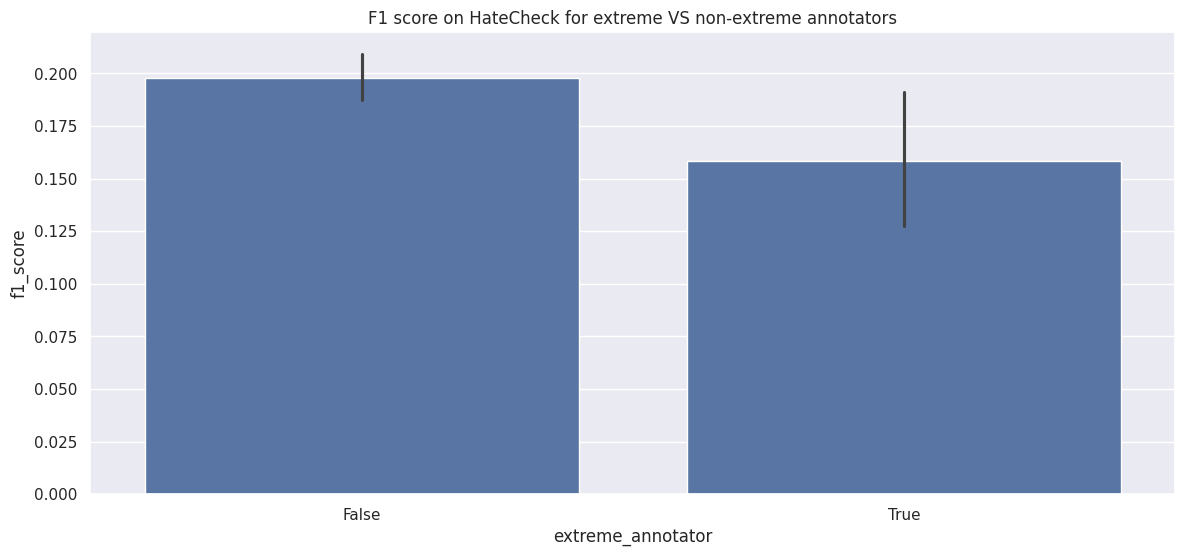

In [27]:
fig = plt.figure(figsize=(14, 6))

sns.barplot(
    data=sephead_hatecheck_annotators_metrics,
    x='extreme_annotator',
    y='f1_score'
)

plt.title('F1 score on HateCheck for extreme VS non-extreme annotators')